In [62]:
import importlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np
from PIL import Image

import Helper_Build_UNet_Model
import Helper_Create_Postprocessing_Model
import Helper_Calc_Mean_Alias_Value_Of_One_Image 

importlib.reload(Helper_Build_UNet_Model)
importlib.reload(Helper_Create_Postprocessing_Model)
importlib.reload(Helper_Calc_Mean_Alias_Value_Of_One_Image)

from Helper_Build_UNet_Model import build_unet_model
from Helper_Create_Postprocessing_Model import create_postprocessing_model, tf_inv_fourier_trans
from Helper_Calc_Mean_Alias_Value_Of_One_Image import calc_mean_alias_value_of_one_image

from tqdm import tqdm

import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images

import time


In [63]:
model_cnn = tf.keras.models.load_model("./cnn_models/single_rgb_image_regression_V02_epochs_100_1653595623")


In [64]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Load Images

In [65]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [66]:
train_filmed_imgs = []
train_clean_imgs = []

In [67]:
OFFSET = 200
abbruch_idx = 30


def my_train_filmed_gen():
    for i, addr_filmed in enumerate(os.listdir(TRAIN_FILMED_PATH)):
        img =  plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]

def my_train_clean_gen():
    for i, addr_clean in enumerate(os.listdir(TRAIN_CLEAN_PATH)):
        img =  plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]


train_filmed_img_gen_obj = my_train_filmed_gen()
train_clean_img_gen_obj = my_train_clean_gen()

## Build U-Net-Model

In [68]:
model_u_net = build_unet_model(IMG_WIDTH, IMG_HEIGHT)
# model_u_net.summary()


# Build Postprecessing Model

In [69]:
# postprocessing_model = create_postprocessing_model()
# postprocessing_model.summary()


## Custom Train loop


In [70]:
# Custom train loop

SAFE_RESULTS = True
WRITE_PATH = "D:\\Main\\MA_PROGR\\Data\\UNET_Output\\Session11"

show_intermediate_pics = False

RGB_WEIGHTS = [0.299, 0.587, 0.114]


overall_train_loss = []

execute_UNet_model = tf.function(model_u_net)
execute_cnn_model = tf.function(model_cnn)
# execute_postprocessing_model = tf.function(postprocessing_model)

NUM_EPOCHS = 20
batch_size_cnn = 1
batch_size_unet = 5


optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanAbsoluteError()
epoch_loss = tf.keras.metrics.MeanAbsoluteError()


train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

y_true = tf.constant(0, dtype=tf.float16, name="y_true")

jump_to_new_epoch = False

for epoch in range(NUM_EPOCHS):

    print(f"Start of epoch {epoch}")
    jump_to_new_epoch = False

    # Mache neue Generater, sodass wieder durch alle Bilder durchgegange wird für die nächste Epoche:
    train_filmed_img_gen_obj = my_train_filmed_gen()
    train_clean_img_gen_obj = my_train_clean_gen()

    # ---------------------------------------------------------------------------- BATCHES SAMMELN Start ----------------------------------------------------------------------------------------
    train_step = 0

    for batch_idx in tqdm(range(batch_size_unet), desc="training...", ascii=False, ncols=75):
        print("next batch...")
        cnn_mean_prediction_values = []

        with tf.GradientTape() as tape:

            # Bilder für den nächsten Batch sammeln:
            for i in range(batch_size_unet):
                try:
                    x_filmed = train_filmed_img_gen_obj.__next__()
                    x_clean = train_clean_img_gen_obj.__next__()
                except StopIteration as e:
                    print(
                        "------------------------Am Ende angelangt, gehe in neue Epoche")

                    jump_to_new_epoch = True

                if jump_to_new_epoch == True:
                    # Alle Bilder sind aufgebraucht, gehe in neue Epoche
                    break

                y_pred, differenzbild_fourier_px, u_net_output, image_processed_rgb = calc_mean_alias_value_of_one_image(
                    x_filmed,
                    x_clean,
                    show_intermediate_pics,
                    IMG_WIDTH,
                    IMG_HEIGHT,
                    execute_cnn_model,
                    execute_UNet_model
                )
                cnn_mean_prediction_values.append(y_pred)

                # print("y_pred: ")
                # print(y_pred)

                # ---------------------------------------------------------------------------- BATCHES SAMMELN ENDE ----------------------------------------------------------------------------------------


            if SAFE_RESULTS:
                plt.imsave(
                    f"{WRITE_PATH}\\x_filmed_{epoch}_{batch_idx}.png", x_filmed)
                plt.imsave(
                    f"{WRITE_PATH}\\x_clean_{epoch}_{batch_idx}.png", x_clean)

                plt.imsave(f"{WRITE_PATH}\\differenzbild_{epoch}_{batch_idx}.png",
                           differenzbild_fourier_px.reshape((IMG_WIDTH, IMG_HEIGHT)), cmap="gray")



                u_net_output_for_img_save = np.array(u_net_output).reshape(IMG_WIDTH, IMG_HEIGHT)
                print("---------------> u_net_output_for_img_save")
                print(u_net_output_for_img_save)
                plt.imsave(f"{WRITE_PATH}\\unet_output_{epoch}_{batch_idx}.png",
                           u_net_output_for_img_save, cmap="gray")

                # image_processed_rgb umformen in Numpy-Array
                image_processed_rgb_for_img_save = np.array(
                    image_processed_rgb).reshape((IMG_WIDTH, IMG_HEIGHT, 3))
                try:
                    plt.imsave(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.png", image_processed_rgb_for_img_save)
                except ValueError:
                    print("------------------------- Speichern hat nicht geklappt, speichere stattdessen numpy array zur Inspektion:")
                    np.save(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.npy", image_processed_rgb_for_img_save)


            if jump_to_new_epoch == True:
                # Alle Bilder sind aufgebraucht, gehe in neue epoche
                break

            # ----------- Calc loss for one batch -----------

            y_true = tf.zeros(batch_size_unet, 1)

            # print("cnn_mean_prediction_values.shape: ")
            # print(np.array(cnn_mean_prediction_values).shape)

            loss = loss_fn(y_true=y_true, y_pred=cnn_mean_prediction_values)
            # print("loss for one batch: ")
            # print(loss)

            gradients = tape.gradient(loss, model_u_net.trainable_weights)
            del cnn_mean_prediction_values[:]
            # print("gradients: ")
            # print(gradients)

            # Optimize the model:
            optimizer.apply_gradients(
                zip(gradients, model_u_net.trainable_variables))

            tmp = epoch_loss.update_state(y_true, y_pred)

            # print("tmp")
            # print(tmp)

            # print("------------------------------------")
            # print("y_true:")
            # print(y_true)

            # print("y_pred")
            # print(y_pred)
            # print("------------------------------------")

            # with train_writer.as_default():
            #     tf.summary.scalar("Loss", loss, step=train_step)
            #     tf.summary.scalar(
            #         "Accuracy", epoch_loss.result(), step=train_step,
            #     )
            # train_step += 1

        # End Epoch

        print(f"--------------- epoch_loss: {epoch_loss.result()}")
        overall_train_loss.append(epoch_loss.result())


# overall_train_loss = epoch_loss.result()
# print(f"overall_train_loss: {overall_train_loss}")
# epoch_loss.reset_states()




Start of epoch 0


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.49999666 0.50000626 0.50000215 ... 0.50000036 0.50000817 0.49998066]
 [0.49999017 0.5000083  0.4999796  ... 0.49999705 0.4999979  0.5       ]
 [0.4999914  0.4999898  0.49999684 ... 0.49997512 0.5000014  0.5000143 ]
 ...
 [0.4999844  0.5000178  0.5000022  ... 0.49998847 0.5000174  0.49997404]
 [0.4999891  0.4999862  0.50001085 ... 0.4999638  0.4999623  0.5000028 ]
 [0.49999693 0.49999523 0.4999936  ... 0.49998507 0.49998444 0.49997732]]


training...:  20%|█████▍                     | 1/5 [00:05<00:22,  5.74s/it]

--------------- epoch_loss: 0.11852774769067764
next batch...
---------------> u_net_output_for_img_save
[[0.50077933 0.50049883 0.50104433 ... 0.500506   0.50128824 0.5010393 ]
 [0.50184184 0.500821   0.50160134 ... 0.50160253 0.50131553 0.50101393]
 [0.5009197  0.50061786 0.5020105  ... 0.50001645 0.5012471  0.5009585 ]
 ...
 [0.50191736 0.5010712  0.50163716 ... 0.5021497  0.5018338  0.50136894]
 [0.5010047  0.50090456 0.5019948  ... 0.5005587  0.5013735  0.50113714]
 [0.5009246  0.5008561  0.50092244 ... 0.5010157  0.5006981  0.50094205]]


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.27s/it]

--------------- epoch_loss: 0.11451566219329834
next batch...
---------------> u_net_output_for_img_save
[[0.50260425 0.5014499  0.5022338  ... 0.5024053  0.50229704 0.5016639 ]
 [0.5037888  0.50164515 0.50390136 ... 0.5020307  0.503353   0.50193775]
 [0.50255513 0.5029846  0.5027301  ... 0.503899   0.50333035 0.50218785]
 ...
 [0.5034159  0.5032825  0.5039908  ... 0.50403285 0.50353056 0.50322974]
 [0.50270534 0.5035139  0.5032955  ... 0.50336856 0.50361323 0.50138885]
 [0.50207406 0.50105757 0.502319   ... 0.50189704 0.5016695  0.5016387 ]]


training...:  60%|████████████████▏          | 3/5 [00:15<00:10,  5.08s/it]

--------------- epoch_loss: 0.11771424859762192
next batch...
---------------> u_net_output_for_img_save
[[0.5032771  0.5036489  0.503381   ... 0.5039892  0.5044865  0.501514  ]
 [0.5073529  0.5043528  0.50759137 ... 0.506154   0.5055327  0.50281566]
 [0.5045988  0.50763685 0.50476027 ... 0.5063263  0.5052158  0.50318104]
 ...
 [0.5083105  0.50496435 0.5068337  ... 0.50519127 0.5048173  0.5034699 ]
 [0.50504154 0.5058944  0.5046636  ... 0.5063796  0.5059874  0.5030908 ]
 [0.5044305  0.50368243 0.50433284 ... 0.50434387 0.5024472  0.5023896 ]]


training...:  80%|█████████████████████▌     | 4/5 [00:20<00:04,  4.96s/it]

--------------- epoch_loss: 0.11629865318536758
next batch...
---------------> u_net_output_for_img_save
[[0.5040373  0.50358987 0.50503826 ... 0.5050264  0.5055975  0.50292987]
 [0.51054174 0.50658053 0.5115277  ... 0.5078634  0.509704   0.50385207]
 [0.50612134 0.50484604 0.5062734  ... 0.50738406 0.5083291  0.5035921 ]
 ...
 [0.514891   0.5081692  0.5094376  ... 0.5093948  0.510895   0.5067374 ]
 [0.50646144 0.5068242  0.50621706 ... 0.507747   0.507088   0.5047491 ]
 [0.5071582  0.50477725 0.5055458  ... 0.5057604  0.5042028  0.5042551 ]]


training...: 100%|███████████████████████████| 5/5 [00:25<00:00,  5.03s/it]


--------------- epoch_loss: 0.11152007430791855
Start of epoch 1


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.5060354  0.50496864 0.5103689  ... 0.50786984 0.50746393 0.5019241 ]
 [0.5174464  0.51065165 0.5183416  ... 0.5115808  0.5146838  0.49926466]
 [0.50819635 0.5102125  0.5075035  ... 0.5089632  0.51152956 0.5061616 ]
 ...
 [0.5187498  0.5107359  0.5138606  ... 0.5146976  0.51334596 0.5094986 ]
 [0.508186   0.51091295 0.5063719  ... 0.50984114 0.50741214 0.5041849 ]
 [0.51155955 0.50010127 0.50529635 ... 0.5052758  0.50581115 0.5057466 ]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.87s/it]

--------------- epoch_loss: 0.11101967096328735
next batch...
---------------> u_net_output_for_img_save
[[0.5132538  0.5060788  0.5087591  ... 0.51239544 0.51349324 0.49913236]
 [0.5442241  0.5197746  0.54323363 ... 0.52523303 0.52356285 0.50029874]
 [0.5134372  0.5240627  0.5239862  ... 0.49950072 0.515282   0.515531  ]
 ...
 [0.5520022  0.52324367 0.5195916  ... 0.51334524 0.51754755 0.51457655]
 [0.5135301  0.51881117 0.51050144 ... 0.51014745 0.5190717  0.508531  ]
 [0.52418554 0.4990884  0.5107295  ... 0.50307304 0.5052152  0.5077416 ]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.79s/it]

--------------- epoch_loss: 0.10937970876693726
next batch...
---------------> u_net_output_for_img_save
[[0.5131096  0.5387288  0.53799474 ... 0.54053175 0.54207677 0.48926872]
 [0.5917255  0.5318769  0.5858983  ... 0.5766275  0.54064566 0.51546425]
 [0.5382695  0.57687193 0.53345424 ... 0.535904   0.5522034  0.51464677]
 ...
 [0.6093279  0.56200314 0.478486   ... 0.55922633 0.5451437  0.5302753 ]
 [0.5080121  0.5289936  0.518993   ... 0.50557226 0.5081176  0.51482725]
 [0.5465785  0.5008623  0.5228015  ... 0.51085126 0.5064862  0.52002245]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.78s/it]

--------------- epoch_loss: 0.09805769473314285
next batch...
---------------> u_net_output_for_img_save
[[0.6379454  0.6163071  0.4852663  ... 0.6766748  0.6707125  0.40737087]
 [0.8962985  0.56037104 0.8416383  ... 0.7855931  0.75041604 0.5399279 ]
 [0.6532911  0.55123734 0.7516955  ... 0.672619   0.62915844 0.6046068 ]
 ...
 [0.96540576 0.6000866  0.5615639  ... 0.6280367  0.5573479  0.6015949 ]
 [0.6390094  0.65905374 0.7508113  ... 0.5357006  0.49844518 0.5037447 ]
 [0.79379654 0.5384999  0.5266652  ... 0.5127193  0.47407338 0.54743767]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.81s/it]

--------------- epoch_loss: 0.08896812796592712
next batch...
---------------> u_net_output_for_img_save
[[0.851324   0.92260695 0.7971359  ... 0.4880866  0.8713068  0.70991844]
 [0.99993557 0.99446595 0.9999405  ... 0.98252726 0.9562782  0.5743513 ]
 [0.99287826 0.9533641  0.9846302  ... 0.53908765 0.805176   0.60284424]
 ...
 [0.99996984 0.9945339  0.86641437 ... 0.9569264  0.86791307 0.82662106]
 [0.7947662  0.77137506 0.9540963  ... 0.53473103 0.6641057  0.580327  ]
 [0.9777852  0.6490496  0.5036072  ... 0.4397279  0.46637344 0.6843962 ]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.81s/it]


--------------- epoch_loss: 0.08224301785230637
Start of epoch 2


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.99924433 0.9913324  0.92648846 ... 0.9880351  0.9846005  0.07026395]
 [1.         0.99999845 1.         ... 0.99999654 0.999969   0.06164056]
 [0.9998908  0.9999964  0.99920607 ... 0.3305099  0.99715    0.96352386]
 ...
 [1.         1.         0.9998441  ... 0.9861638  0.9888636  0.972877  ]
 [0.8944051  0.99989814 0.99844885 ... 0.9882045  0.96576655 0.65581226]
 [0.9997792  0.02011082 0.6275026  ... 0.554971   0.3084711  0.7270442 ]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.76s/it]

--------------- epoch_loss: 0.07868241518735886
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 9.9999988e-01 9.9989831e-01 ... 9.9997985e-01
  9.9992871e-01 2.2606164e-02]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  9.9999106e-01 1.1858672e-02]
 [4.1646177e-01 1.0000000e+00 9.9999923e-01 ... 7.3300183e-01
  9.8588544e-01 9.7134399e-01]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  9.9999726e-01 9.9998379e-01]
 [9.9999952e-01 9.9999833e-01 9.7593009e-01 ... 1.9264579e-02
  1.8639207e-02 8.0281514e-01]
 [1.0000000e+00 8.0460641e-06 8.0705196e-02 ... 1.7910600e-01
  8.4282458e-01 9.9035072e-01]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.79s/it]

--------------- epoch_loss: 0.0729752853512764
next batch...
---------------> u_net_output_for_img_save
[[1.00000000e+00 1.00000000e+00 9.99628186e-01 ... 1.00000000e+00
  1.00000000e+00 2.38522269e-09]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 4.46623396e-08]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 5.41329324e-01
  1.00000000e+00 9.95773196e-01]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 9.99974251e-01]
 [1.00000000e+00 9.99959528e-01 9.99310017e-01 ... 2.83622654e-08
  9.97303963e-01 1.50381029e-01]
 [1.00000000e+00 3.00590912e-08 1.05152285e-04 ... 3.96496058e-03
  1.05878204e-01 9.16479290e-01]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.88s/it]

--------------- epoch_loss: 0.06816093623638153
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 2.5688404e-01 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 8.8581613e-15]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 3.5564360e-11]
 [1.0000000e+00 3.6707841e-06 1.9552200e-28 ... 9.9996531e-01
  1.0000000e+00 1.9988000e-02]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 9.9991214e-01]
 [1.0000000e+00 1.0000000e+00 7.1306528e-12 ... 8.5496455e-02
  6.5712911e-01 4.1772038e-02]
 [1.0000000e+00 1.4679258e-22 1.0000000e+00 ... 9.6368790e-04
  9.9925101e-01 2.7360156e-01]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.88s/it]

--------------- epoch_loss: 0.06398191303014755
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.8901981e-30]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.4550250e-22]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.7241394e-17
  1.0000000e+00 9.9837953e-01]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 7.9664767e-35 ... 2.9622910e-25
  8.9822323e-21 2.0112577e-24]
 [1.0000000e+00 0.0000000e+00 2.7025060e-10 ... 1.6237428e-22
  1.0000000e+00 2.0723855e-01]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.87s/it]


--------------- epoch_loss: 0.06044355407357216
Start of epoch 3


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 9.9999988e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.8361913e-21]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.8032094e-32
  1.0000000e+00 2.5530519e-24]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 9.9992788e-01]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.3338955e-36
  1.7267930e-20 1.4696178e-22]
 [1.0000000e+00 0.0000000e+00 1.2408279e-14 ... 0.0000000e+00
  9.9999809e-01 1.0000000e+00]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.84s/it]

--------------- epoch_loss: 0.057810161262750626
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 9.0247015e-32 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0969891e-04]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 3.0300774e-32]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 9.9837363e-01
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.7406201e-13]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 9.9749100e-01 ... 0.0000000e+00
  8.0619410e-15 2.1639466e-04]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.78s/it]

--------------- epoch_loss: 0.05558698996901512
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 3.2238367e-19
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  3.2010521e-36 1.4600562e-38]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.2270202e-27
  1.0000000e+00 1.0000000e+00]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.88s/it]

--------------- epoch_loss: 0.05295965448021889
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999708e-01
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.6440272e-02]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.3029628e-15 3.7964553e-12]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.86s/it]

--------------- epoch_loss: 0.05063033103942871
next batch...
---------------> u_net_output_for_img_save
[[1.000000e+00 0.000000e+00 1.000000e+00 ... 1.880911e-01 1.000000e+00
  0.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 9.999760e-01
  0.000000e+00]
 ...
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  8.051663e-33]
 [1.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 1.000000e+00
  1.000000e+00]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.83s/it]


--------------- epoch_loss: 0.048596642911434174
Start of epoch 4


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  8.3881518e-10 3.3605658e-21]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.74s/it]

--------------- epoch_loss: 0.047691162675619125
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0241408e-36 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  9.9995846e-01 1.1779467e-37]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.79s/it]

--------------- epoch_loss: 0.04625455290079117
next batch...
---------------> u_net_output_for_img_save
[[1.         0.         1.         ... 1.         1.         0.        ]
 [1.         1.         1.         ... 1.         1.         0.        ]
 [1.         0.         1.         ... 0.         1.         0.        ]
 ...
 [1.         1.         1.         ... 1.         1.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.27322826 1.        ]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.83s/it]

--------------- epoch_loss: 0.04513220861554146
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.83s/it]

--------------- epoch_loss: 0.043708499521017075
next batch...
---------------> u_net_output_for_img_save
[[1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 ...
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 7.537439e-22
  0.000000e+00]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.82s/it]


--------------- epoch_loss: 0.04241715371608734
Start of epoch 5


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.8950088e-05 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.74s/it]

--------------- epoch_loss: 0.041639842092990875
next batch...
---------------> u_net_output_for_img_save
[[1.         0.         1.         ... 0.         1.         0.        ]
 [1.         1.         1.         ... 1.         1.         0.        ]
 [1.         0.         1.         ... 0.         1.         0.        ]
 ...
 [1.         0.00338516 1.         ... 1.         1.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 0.         1.         0.9998126 ]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.78s/it]

--------------- epoch_loss: 0.04032561182975769
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 2.8021282e-06]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.87s/it]

--------------- epoch_loss: 0.039117030799388885
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.90s/it]

--------------- epoch_loss: 0.03812041133642197
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  3.7101764e-18 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 2.1029650e-28]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.87s/it]


--------------- epoch_loss: 0.03718908131122589
Start of epoch 6


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.79s/it]

--------------- epoch_loss: 0.03645559772849083
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.84s/it]

--------------- epoch_loss: 0.03566945344209671
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 0. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.99s/it]

--------------- epoch_loss: 0.03487624228000641
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 0. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.93s/it]

--------------- epoch_loss: 0.03407192602753639
next batch...
---------------> u_net_output_for_img_save
[[1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.3469027e-15]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.95s/it]


--------------- epoch_loss: 0.0334903709590435
Start of epoch 7


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 ...
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 8.888544e-33 ... 0.000000e+00 1.000000e+00
  0.000000e+00]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.95s/it]

--------------- epoch_loss: 0.03278369456529617
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.82s/it]

--------------- epoch_loss: 0.03226124122738838
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.83s/it]

--------------- epoch_loss: 0.031568191945552826
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.81s/it]

--------------- epoch_loss: 0.03085416741669178
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.83s/it]


--------------- epoch_loss: 0.030351126566529274
Start of epoch 8


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.94s/it]

--------------- epoch_loss: 0.0299517959356308
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.91s/it]

--------------- epoch_loss: 0.029723037034273148
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.91s/it]

--------------- epoch_loss: 0.02915104106068611
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.87s/it]

--------------- epoch_loss: 0.02861330658197403
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.88s/it]


--------------- epoch_loss: 0.02818869985640049
Start of epoch 9


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1.00000e+00 0.00000e+00 1.00000e+00 ... 1.00000e+00 1.00000e+00
  0.00000e+00]
 [1.00000e+00 1.00000e+00 1.00000e+00 ... 1.00000e+00 1.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 ...
 [1.00000e+00 1.00000e+00 1.00000e+00 ... 1.00000e+00 1.00000e+00
  0.00000e+00]
 [6.53161e-34 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.83s/it]

--------------- epoch_loss: 0.02784019708633423
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.78s/it]

--------------- epoch_loss: 0.027697786688804626
next batch...
---------------> u_net_output_for_img_save
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.81s/it]

--------------- epoch_loss: 0.027234850451350212
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.83s/it]

--------------- epoch_loss: 0.026770886033773422
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.83s/it]


--------------- epoch_loss: 0.026667919009923935
Start of epoch 10


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:05<00:20,  5.02s/it]

--------------- epoch_loss: 0.026395924389362335
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.98s/it]

--------------- epoch_loss: 0.026259519159793854
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.92s/it]

--------------- epoch_loss: 0.025884544476866722
next batch...
---------------> u_net_output_for_img_save
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.94s/it]

--------------- epoch_loss: 0.02575383335351944
next batch...
---------------> u_net_output_for_img_save
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.94s/it]


--------------- epoch_loss: 0.025611959397792816
Start of epoch 11


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.91s/it]

--------------- epoch_loss: 0.02558210864663124
next batch...
---------------> u_net_output_for_img_save
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.87s/it]

--------------- epoch_loss: 0.025711912661790848
next batch...
---------------> u_net_output_for_img_save
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.90s/it]

--------------- epoch_loss: 0.025501295924186707
next batch...
---------------> u_net_output_for_img_save
[[1.        0.9222156 1.        ... 1.        1.        1.       ]
 [1.        1.        1.        ... 1.        1.        0.       ]
 [1.        0.        1.        ... 0.        1.        0.       ]
 ...
 [1.        1.        1.        ... 1.        1.        0.       ]
 [0.        0.        1.        ... 0.        1.        0.       ]
 [1.        0.        1.        ... 0.        1.        0.       ]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.92s/it]

--------------- epoch_loss: 0.025369247421622276
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.91s/it]


--------------- epoch_loss: 0.02523036114871502
Start of epoch 12


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.80s/it]

--------------- epoch_loss: 0.025400253012776375
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.87s/it]

--------------- epoch_loss: 0.025476595386862755
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.93s/it]

--------------- epoch_loss: 0.02535833790898323
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.95s/it]

--------------- epoch_loss: 0.02531176619231701
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.93s/it]


--------------- epoch_loss: 0.02525591291487217
Start of epoch 13


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  5.00s/it]

--------------- epoch_loss: 0.02516745962202549
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.06s/it]

--------------- epoch_loss: 0.025261346250772476
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:15<00:09,  4.99s/it]

--------------- epoch_loss: 0.025324568152427673
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:20<00:05,  5.05s/it]

--------------- epoch_loss: 0.025162911042571068
next batch...
---------------> u_net_output_for_img_save
[[0. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:25<00:00,  5.01s/it]


--------------- epoch_loss: 0.0251933466643095
Start of epoch 14


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.92s/it]

--------------- epoch_loss: 0.025217205286026
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.90s/it]

--------------- epoch_loss: 0.025114260613918304
next batch...
---------------> u_net_output_for_img_save
[[1.00000e+00 0.00000e+00 1.00000e+00 ... 5.32078e-14 1.00000e+00
  1.00000e+00]
 [1.00000e+00 1.00000e+00 1.00000e+00 ... 1.00000e+00 1.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 ...
 [1.00000e+00 1.00000e+00 1.00000e+00 ... 1.00000e+00 1.00000e+00
  0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]
 [1.00000e+00 1.00000e+00 1.00000e+00 ... 0.00000e+00 1.00000e+00
  0.00000e+00]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:10,  5.01s/it]

--------------- epoch_loss: 0.024995572865009308
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.97s/it]

--------------- epoch_loss: 0.024840248748660088
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.97s/it]


--------------- epoch_loss: 0.024698631837964058
Start of epoch 15


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.88s/it]

--------------- epoch_loss: 0.024605870246887207
next batch...
---------------> u_net_output_for_img_save
[[1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  7.943213e-04]
 ...
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.96s/it]

--------------- epoch_loss: 0.024751899763941765
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:10,  5.00s/it]

--------------- epoch_loss: 0.024475544691085815
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:20<00:05,  5.06s/it]

--------------- epoch_loss: 0.024281863123178482
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:25<00:00,  5.03s/it]


--------------- epoch_loss: 0.02416948601603508
Start of epoch 16


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:05<00:20,  5.07s/it]

--------------- epoch_loss: 0.02401822805404663
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.11s/it]

--------------- epoch_loss: 0.023977819830179214
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:15<00:10,  5.07s/it]

--------------- epoch_loss: 0.02373569644987583
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:20<00:05,  5.13s/it]

--------------- epoch_loss: 0.023530596867203712
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:25<00:00,  5.08s/it]


--------------- epoch_loss: 0.023448331281542778
Start of epoch 17


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:05<00:20,  5.05s/it]

--------------- epoch_loss: 0.023532425984740257
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.01s/it]

--------------- epoch_loss: 0.023350222036242485
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:15<00:10,  5.04s/it]

--------------- epoch_loss: 0.023189539089798927
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:20<00:05,  5.03s/it]

--------------- epoch_loss: 0.023023659363389015
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:25<00:00,  5.02s/it]


--------------- epoch_loss: 0.022904545068740845
Start of epoch 18


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.87s/it]

--------------- epoch_loss: 0.02281046472489834
next batch...
---------------> u_net_output_for_img_save
[[1.000000e+00 0.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  1.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 ...
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [3.137148e-23 1.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.90s/it]

--------------- epoch_loss: 0.02270066924393177
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.92s/it]

--------------- epoch_loss: 0.022539889439940453
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.97s/it]

--------------- epoch_loss: 0.022372668609023094
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.94s/it]


--------------- epoch_loss: 0.022241486236453056
Start of epoch 19


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:05<00:20,  5.05s/it]

--------------- epoch_loss: 0.022099370136857033
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.17s/it]

--------------- epoch_loss: 0.021954435855150223
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:15<00:10,  5.09s/it]

--------------- epoch_loss: 0.02178877964615822
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:20<00:05,  5.08s/it]

--------------- epoch_loss: 0.021633919328451157
next batch...
---------------> u_net_output_for_img_save
[[1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:25<00:00,  5.08s/it]

--------------- epoch_loss: 0.021498601883649826


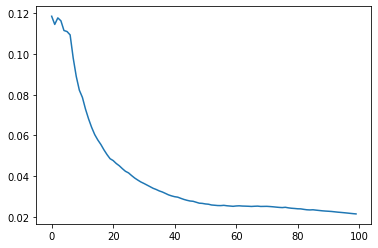

In [71]:

plt.plot(overall_train_loss)

In [80]:
len(np.array(overall_train_loss))


100

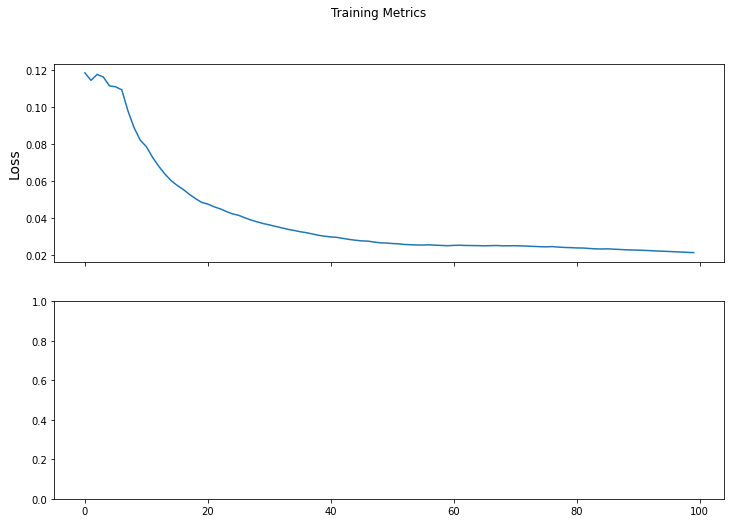

In [72]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(overall_train_loss)

plt.show()


In [73]:
# test_img = img[400:528, 400:528,:]
# test_img = np.array(test_img).reshape(1, 128 , 128 , 3)

# # plt.imshow(test_img)

# test_img= tf.convert_to_tensor(test_img, dtype=tf.float32)

# test_img


In [74]:
# import tensorflow as tf
# BATCH_SIZE = 1
# NUM_BOXES = 3
# IMAGE_HEIGHT = 128
# IMAGE_WIDTH = 128
# CHANNELS = 3
# CROP_SIZE = (24, 24)

# test_img = img[400:528, 400:528, :]
# test_img = np.array(test_img).reshape(1, 128, 128, 3)

# # plt.imshow(test_img)

# test_img = tf.convert_to_tensor(test_img, dtype=tf.float32)
# image = test_img
# boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# # plt.imshow(np.array(image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# # plt.show()
# box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
#                                 maxval=BATCH_SIZE, dtype=tf.int32)
# output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
# output.shape  # => (5, 24, 24, 3)

# plt.imshow(output[2])
